# 📈 Forecasting Synthetic Time Series with LSTM

This example demonstrates how to generate synthetic time series data using **`tsg-lib`** and train a simple LSTM model to forecast future values.

Synthetic time series allow you to test forecasting models on data with known properties — such as trends, noise, or regime shifts — before applying them to real-world datasets.

In this example, we:
- Generate a linear trend with Gaussian noise using **`tsg-lib`**
- Prepare the data for supervised learning with an LSTM
- Train the LSTM to predict the next time step
- Visualize how well the model captures the underlying pattern


---

> This tutorial shows how **`tsg-lib`** can be used for developing and testing forecasting models in research or applied machine learning.


## 🚀 Getting Started

Make sure you have the following Python packages installed:

- **`tsg-lib`** — for synthetic time series generation  
- **`torch`** — for building and training the LSTM model  
- **`numpy`** — for data manipulation and preprocessing  
- **`matplotlib`** — for visualization of results  
- **`scikit-learn`** — for evaluation metrics (e.g., Mean Squared Error)  

You can install them with:

```bash
pip install tsg-lib torch numpy matplotlib scikit-learn
```

In [21]:
# 📦 Imports
from tsg.generators import LinearTrendGenerator, OrnsteinUhlenbeckGenerator
from tsg.modifiers import GaussianNoise
from tsg.meta_generators import MarkovSwitchGenerator

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error


## 🗂️ Synthetic Data Creation with `tsg-lib`

In this section, we generate synthetic time series data using **`tsg-lib`**.  
We create three different types of series:
- **Linear Trend with Gaussian Noise** — a simple upward trend with random fluctuations.
- **Ornstein-Uhlenbeck Process** — a mean-reverting stochastic process.
- **Markov Switching Series** — a process that switches between the two regimes according to a Markov chain.

These series will be used to train and evaluate forecasting models in the next steps.


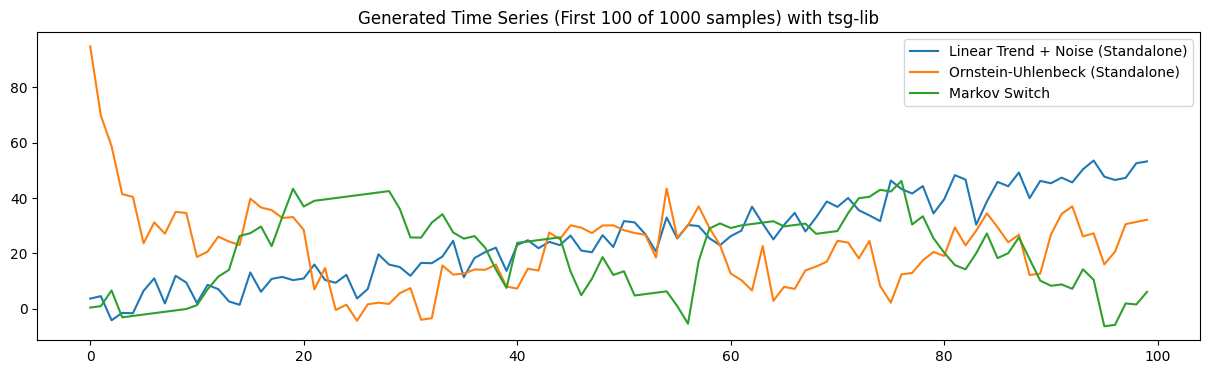

In [22]:
# 📏 Set Time Series Length Here
series_length = 1000


# 📈 1️⃣ Linear Trend with Gaussian Noise (Instance for Standalone Series)
linear_trend = LinearTrendGenerator(start_value=0.0, slope=0.5)
noisy_linear = GaussianNoise(linear_trend, mu=0.0, sigma=5.0)
linear_series = [noisy_linear.generate_value(None) for _ in range(series_length)]

# 📉 2️⃣ Ornstein-Uhlenbeck Process (Instance for Standalone Series)
ou_process = OrnsteinUhlenbeckGenerator(mu=20.0, theta=0.15, sigma=7, dt=1.0, start_value=100.0)
ou_series = [ou_process.generate_value(None) for _ in range(series_length)]

# 🔁 3️⃣ Markov Switch Generator between LinearTrend + GaussianNoise and OU Process
# Provide CLASSES and PARAMS, not instances
generator_classes = [LinearTrendGenerator, OrnsteinUhlenbeckGenerator]
generator_params_list = [
    {'start_value': 0.0, 'slope': 0.5},  # Params for LinearTrendGenerator
    {'mu': 20.0, 'theta': 0.15, 'sigma': 7, 'dt': 1.0, 'start_value': 100.0}  # Params for OU
]
transition_matrix = np.array([
    [0.8, 0.2],
    [0.2, 0.8]
])

markov_switch = MarkovSwitchGenerator(
    generator_classes=generator_classes,
    generator_params_list=generator_params_list,
    transition_matrix=transition_matrix,
    initial_state=0
)

markov_series = [markov_switch.generate_value(None) for _ in range(series_length)]

# 📏 Set number of points to plot
n_plot = 100  # Change as needed

# 🎨 Plotting
plt.figure(figsize=(15, 4))
plt.plot(linear_series[:n_plot], label='Linear Trend + Noise (Standalone)')
plt.plot(ou_series[:n_plot], label='Ornstein-Uhlenbeck (Standalone)')
plt.plot(markov_series[:n_plot], label='Markov Switch')
plt.title(f'Generated Time Series (First {n_plot} of {series_length} samples) with tsg-lib')
plt.legend()
plt.show()



## 🧠 Time Series Forecasting with LSTM

In this section, we train a simple **LSTM (Long Short-Term Memory)** neural network to forecast the next value of each synthetic time series.  
We use a **rolling window approach** to create input-output pairs for supervised learning.  

For each time series:
- We create training and test datasets.
- We train a separate LSTM model on the training data.
- We evaluate the model by comparing its predictions to the true values on the test set.

This setup demonstrates how recurrent neural networks can learn to forecast patterns in different types of synthetic time series.


LSTM on Linear Trend + Noise — Test MSE: 586.2284


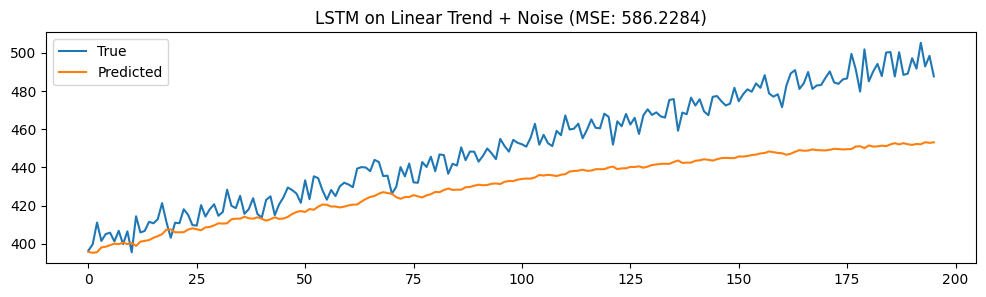

LSTM on Ornstein-Uhlenbeck Process — Test MSE: 56.4264


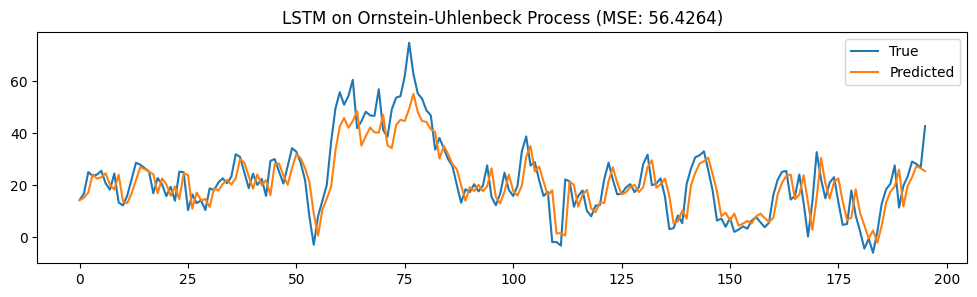

LSTM on Markov Switch Series — Test MSE: 30.0986


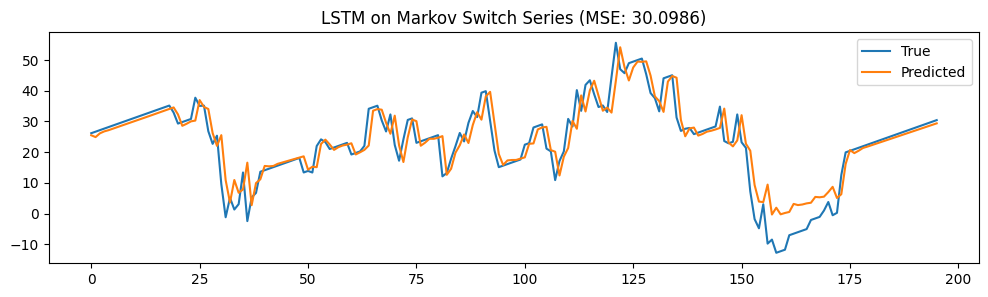

In [23]:
# 🗂️ Rolling Window Dataset Preparation
def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

# 🧠 LSTM Model Definition
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take last output
        return out


def standardize_series(series, mean=None, std=None):
    if mean is None:
        mean = np.mean(series)
    if std is None:
        std = np.std(series)
    return (series - mean) / std, mean, std

def destandardize_series(series, mean, std):
    return series * std + mean

def train_and_plot(series, title, window_size=20, epochs=50, lr=0.01):
    # 🧹 Normalize the entire series using training data statistics later
    X_raw, y_raw = create_dataset(series, window_size)

    split = int(0.8 * len(X_raw))
    X_train_raw, X_test_raw = X_raw[:split], X_raw[split:]
    y_train_raw, y_test_raw = y_raw[:split], y_raw[split:]

    # Compute mean/std from training set only
    X_train_flat = X_train_raw.flatten()
    X_train_flat_std, mean_X, std_X = standardize_series(X_train_flat)
    y_train_std, mean_y, std_y = standardize_series(y_train_raw)

    # Reshape after normalization
    X_train = X_train_flat_std.reshape(X_train_raw.shape)[..., np.newaxis]
    y_train = y_train_std[..., np.newaxis]

    # Apply same scaling on test set
    X_test_flat = X_test_raw.flatten()
    X_test_flat_std = (X_test_flat - mean_X) / std_X
    X_test = X_test_flat_std.reshape(X_test_raw.shape)[..., np.newaxis]
    y_test = (y_test_raw - mean_y) / std_y
    y_test = y_test[..., np.newaxis]

    # Convert to torch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).float()

    # 🧠 Model Setup
    model = SimpleLSTM()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # 🎯 Training
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    # 🔍 Evaluation
    model.eval()
    with torch.no_grad():
        predictions_std = model(X_test_tensor).numpy()

    # Inverse transform predictions and true values
    predictions = destandardize_series(predictions_std.flatten(), mean_y, std_y)
    y_test_true = destandardize_series(y_test.flatten(), mean_y, std_y)

    # 🎯 MSE on Original Scale
    mse = mean_squared_error(y_test_true, predictions)
    print(f"{title} — Test MSE: {mse:.4f}")

    # 🎨 Plotting
    plt.figure(figsize=(12, 3))
    plt.plot(y_test_true, label='True')
    plt.plot(predictions, label='Predicted')
    plt.title(f"{title} (MSE: {mse:.4f})")
    plt.legend()
    plt.show()



# 🏁 Train & Plot on All Three Series
window_size = 20  # Set a window size for LSTM input
train_and_plot(linear_series, "LSTM on Linear Trend + Noise", window_size= window_size)
train_and_plot(ou_series, "LSTM on Ornstein-Uhlenbeck Process", window_size=window_size)
train_and_plot(markov_series, "LSTM on Markov Switch Series", window_size=window_size)


## 📝 Conclusion

In this demo, we showcased how **`tsg-lib`** can be used to generate diverse synthetic time series for modeling and experimentation.  
By combining different generators — such as linear trends with noise, mean-reverting processes, and regime-switching dynamics — we demonstrated how `tsg-lib` serves as a flexible tool for creating controlled time series environments.  

To illustrate a practical application, we trained simple LSTM models on each generated series to show how synthetic data can be used for testing forecasting models.  

### 🔍 Key Takeaways:
- **`tsg-lib`** allows you to create time series with known structures and properties.
- You can easily combine generators and wrappers to simulate realistic or challenging time series behaviors.
- Synthetic data helps explore model behavior, debug algorithms, and benchmark forecasting methods.

---

> **`tsg-lib`** is designed to support research and prototyping in machine learning and sequential decision-making by providing modular, composable time series generators.
